In [11]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

In [12]:
class zero_mean(tf.keras.Model):

    def __init__(self,
                 dtype,
                 name='eq_covariance'):
        
        super().__init__(name=name, dtype=dtype)
        
        
    def __call__(self, x):
        return tf.zeros(x.shape[0], dtype=self.dtype)

In [13]:
class eq_covariance(tf.keras.Model):

    def __init__(self, 
                 log_coeff,
                 log_scales,
                 dim,
                 dtype,
                 name='eq_covariance',
                 **kwargs):
        
        super().__init__(name=name, dtype=dtype, **kwargs)
    
        # Convert parameters to tensors
        log_coeff = tf.convert_to_tensor(log_coeff, dtype=dtype)
        log_scales = tf.convert_to_tensor(log_scales, dtype=dtype)

        # Reshape parameter tensors
        log_coeff = tf.squeeze(log_coeff)
        log_scales = tf.reshape(log_scales, (1, -1))

        assert log_scales.shape[-1] == dim,                \
            f'Expected the size of scales at axis 2 '    + \
            f'to be dim, found shapes {scales.shape} '   + \
            f'and {dim}.'

        assert log_coeff.shape == (),                     \
            f'Expected coeff to be a single scalar, '   + \
            f'found coeff.shape == {coeff.shape}.'
        
        # Set input dimensionality
        self.dim = dim
        
        # Set EQ parameters
        self.log_scales = tf.Variable(log_scales)
        self.log_coeff = tf.Variable(log_coeff)
        
    
    @property
    def scales(self):
        return tf.exp(self.log_scales) ** 2.
    
    
    @property
    def coeff(self):
        return tf.exp(self.log_coeff) ** 2.
        
        
    def __call__(self,
                 x1,
                 x2,
                 diag_only=False,
                 epsilon=None):
        
        # Reshape input tensors
        x1 = tf.convert_to_tensor(x1, dtype=self.dtype)
        x2 = tf.convert_to_tensor(x2, dtype=self.dtype)

        # Check dimensions are correct
        assert (tf.rank(x1) == tf.rank(x2) == 2) and       \
               (x1.shape[1] == x2.shape[1] == self.dim),   \
            f'Expected x1 and x2 to have 2 dimensions '  + \
            f'and to both match self.dim at second '     + \
            f'dimension, instead found shapes '          + \
            f'{x1.shape} and {x2.shape}.'

        scales = self.scales
        
        # If not calculating diagonal only, expand to broadcast
        if not diag_only:

            x1 = x1[:, None, :]
            x2 = x2[None, :, :]

            scales = self.scales[None, :, :]

        # Compute differences
        diffs = x1 - x2

        # Compute quadratic form
        quad = - 0.5 * diffs ** 2 / scales
        quad = tf.reduce_sum(quad, axis=-1)

        # Exponentiate and multiply by covariance coeff
        exp_quad = tf.exp(quad)
        eq_cov = self.coeff ** 2 * exp_quad
        
        # Add epsilon for invertibility
        if epsilon is not None:
            
            eq_cov = eq_cov + epsilon * tf.eye(eq_cov.shape[0], dtype=self.dtype)

        return eq_cov

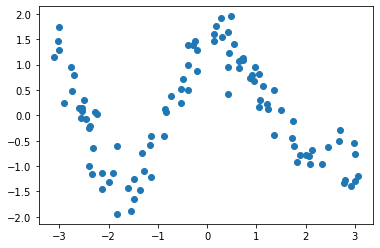

In [14]:
def get_gp_train_data():
    
    tf.random.set_seed(0)
    np.random.seed(0)
    
    num_datapoints = 100
    log_coeff = 0.
    log_noise = -2.
    log_scales = [0.]
    
    x = np.random.uniform(low=-np.pi, high=np.pi, size=(num_datapoints,))
    x = x[:, None]

    mean = zero_mean(dtype=tf.float64)
    mean = mean(x)

    cov = eq_covariance(log_coeff=log_coeff,
                        log_scales=log_scales,
                        dim=1,
                        dtype=tf.float64)
    cov = cov(x, x)
    cov = cov + tf.cast(tf.exp(log_noise), dtype=tf.float64) * tf.eye(cov.shape[0], dtype=tf.float64)

    normal = tfp.distributions.MultivariateNormalFullCovariance
    normal = normal(loc=mean, covariance_matrix=cov)
    
    y = normal.sample()
    
    return x[:, 0], y
    

x, y = get_gp_train_data()

plt.scatter(x, y)
plt.show()

In [ ]:
# Train FITC model initialized from the perfect solution.
FITCmodel = gpflow.models.GPRFITC(
    (x, y), kernel=getKernel(), inducing_variable=Xtrain.copy()
)

initializeHyperparametersFromExactSolution(FITCmodel)

FITCcb = repeatMinimization(FITCmodel, Xtest, Ytest)  # optimize with several restarts
print("Sparse model parameters after FITC optimization:")
printModelParameters(FITCmodel)

In [ ]:
figB, axes = plt.subplots(3, 2, figsize=(20, 16))

# VFE optimization finishes after 10 iterations, so we stretch out the training and test
# log-likelihood traces to make them comparable against FITC:
VFEiters = FITCcb.n_iters
VFElog_likelihoods = stretch(len(VFEiters), VFEcb.log_likelihoods)
VFEhold_out_likelihood = stretch(len(VFEiters), VFEcb.hold_out_likelihood)

axes[0, 0].set_title("VFE", loc="center", fontdict={"fontsize": 22})
plotComparisonFigure(
    Xtrain,
    VFEmodel,
    exact_model,
    axes[0, 0],
    axes[1, 0],
    axes[2, 0],
    VFEiters,
    VFElog_likelihoods,
    VFEhold_out_likelihood,
)

axes[0, 1].set_title("FITC", loc="center", fontdict={"fontsize": 22})
plotComparisonFigure(
    Xtrain,
    FITCmodel,
    exact_model,
    axes[0, 1],
    axes[1, 1],
    axes[2, 1],
    FITCcb.n_iters,
    FITCcb.log_likelihoods,
    FITCcb.hold_out_likelihood,
)